# 1. Install Quandl library

In [1]:
#Import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

# 2. Install data set and import into notebook

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'oTLu8yUaSCzDHceEJL3x'

In [3]:
# Importing the Historical Housing Market Data - Real Home Price variable.

data = quandl.get('YALE/RHPI')

In [9]:
data.head(5)

,Index
Date,
1890-12-31,100.000000
1891-12-31,88.011791
1892-12-31,95.421736
1893-12-31,92.297385
1894-12-31,123.980483


In [10]:
data.shape

(886, 1)

In [11]:
data.columns

Index(['Index'], dtype='object')

In [12]:
type(data)

pandas.core.frame.DataFrame

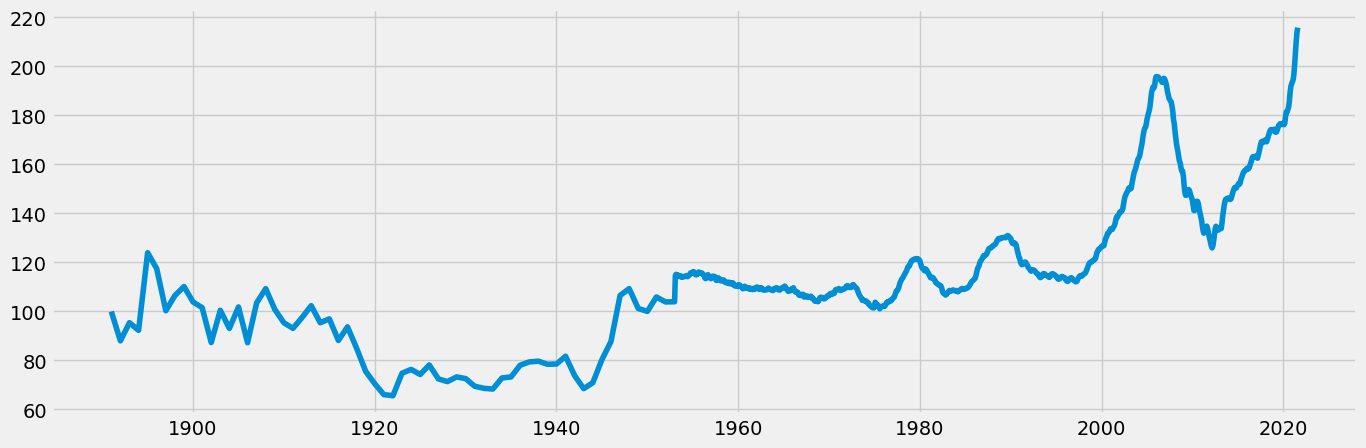

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

In [ ]:
# 3. Make subset of your data set

In [4]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [15]:
data_2.head()

,Date,Index
0,1890-12-31,100.000000
1,1891-12-31,88.011791
2,1892-12-31,95.421736
3,1893-12-31,92.297385
4,1894-12-31,123.980483


In [5]:
data_sub = data_2.loc[(data_2['Date'] >= '1970-12-31') & (data_2['Date'] < '2020-12-31')]

In [19]:
data_sub.shape

(600, 2)

In [20]:
data_sub.head()

,Date,Index
278,1970-12-31,109.080046
279,1971-01-31,109.347180
280,1971-02-28,108.806662
281,1971-03-31,108.534645
282,1971-04-30,108.617500


#### The data set dates back to 1890 all the way to 2020. But I would like to analyse data in the last 50 years as this is more relevant to the present day. I selected a subset covering the period 1970 to 2020. 

#### Reset the index, subset, then reset 'Date' column as index in the dataframe.

In [6]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Index
datetime,
1970-12-31,109.080046
1971-01-31,109.347180
1971-02-28,108.806662
1971-03-31,108.534645
1971-04-30,108.617500


# 4. Create line chart of data.

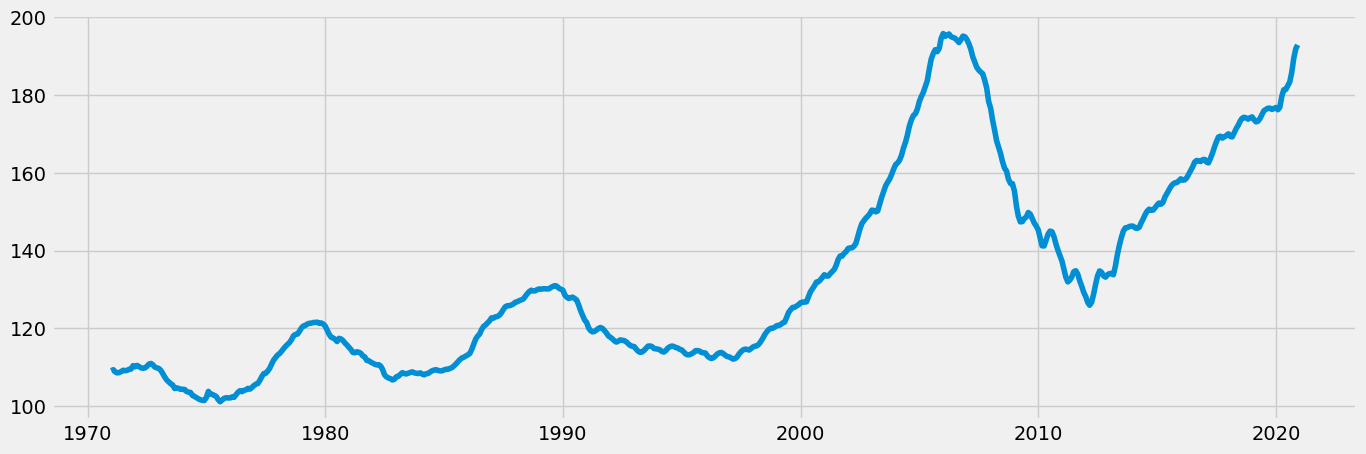

In [22]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [23]:
# Check for missing values

data_sub.isnull().sum() 

# No missing values

Index    0
dtype: int64

In [24]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum() 

# No duplicates

0

# 5. Decompose data's components.

In [7]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [8]:
from pylab import rcParams # To define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

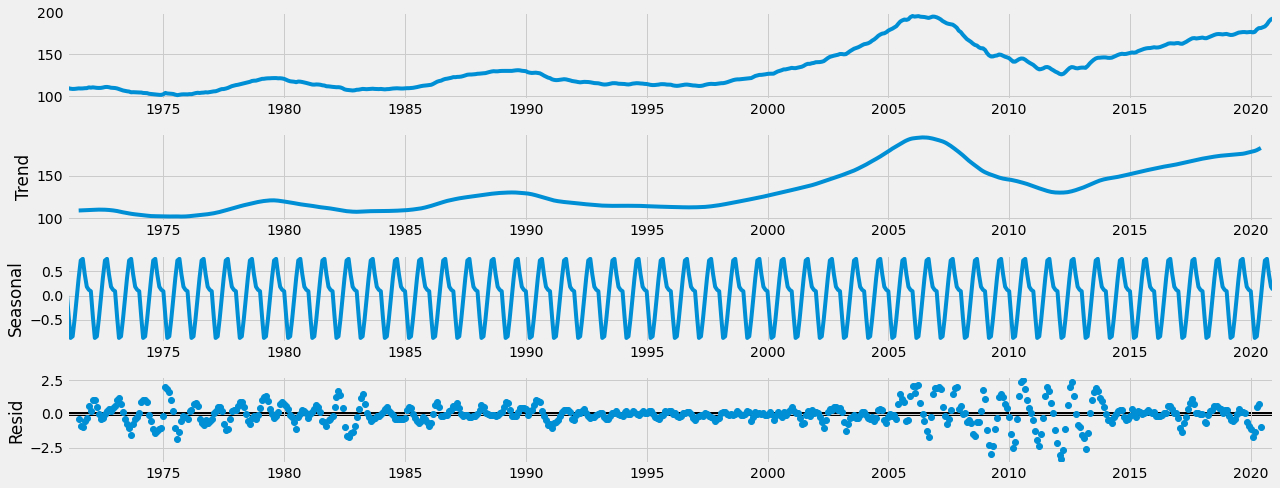

In [9]:
# Plot the separate components

decomposition.plot()
plt.show()

### Analysis of the plot

#### Trend - This is almost a reflection of the level. It moves gradually upward from 1970 to 1997 then sharply rises until 2006. It declines again to 2013 then rises again to 2020.

#### Seasonal - The seasonality is has a regular interval and shows a stationary time series.

#### Resid - There is some degree of noise from 1970 to 1983. This is followed but a period of relatively smooth period. The noise intensifies again from 2005 to 2014. 

# 6. Dickey-Fuller test to check for stationarity.

In [15]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
    
# Apply the test using the function on the time series
dickey_fuller(data_sub['Index'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.368760
p-value                          0.915186
Number of Lags Used             18.000000
Number of Observations Used    581.000000
Critical Value (1%)             -3.441655
Critical Value (5%)             -2.866527
Critical Value (10%)            -2.569426
dtype: float64


#### P-value 0.91 is greater than 0.05 therefore the test result has no significance.

#### The test statistic is greater than the critical values therefore null hypothesis cannot be rejected. This means there is a unit root in the data and that the data is non-stationary.

# 7. Perform differencing for stationarity.

In [23]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff = data_sub - data_sub.shift(1) 

In [36]:
#Remove the missing values that came about as a result of the differencing. 

data_diff.dropna(inplace = True) 

In [37]:
data_diff.head()

,Index
datetime,
1971-01-31,0.267135
1971-02-28,-0.540518
1971-03-31,-0.272017
1971-04-30,0.082855
1971-05-31,0.252417


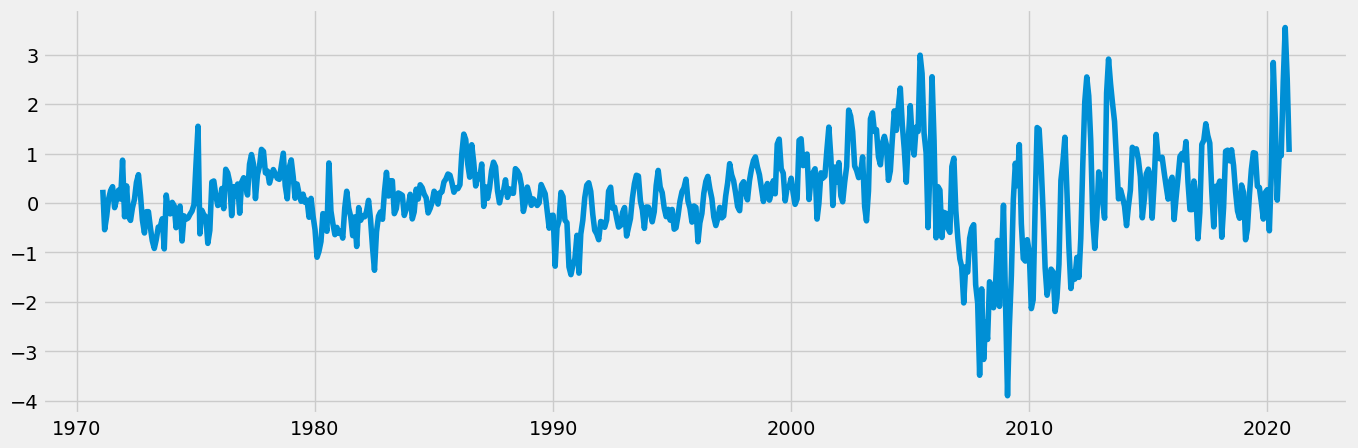

In [38]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [39]:
# Apply the test using the function on the time series

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.536285
p-value                          0.007103
Number of Lags Used             17.000000
Number of Observations Used    581.000000
Critical Value (1%)             -3.441655
Critical Value (5%)             -2.866527
Critical Value (10%)            -2.569426
dtype: float64


#### P-value 0.007 is lesser than 0.05 therefore the test result has significance.

#### The test statistic is lesser than the critical value (5%) therefore null hypothesis can be rejected. This means that the data is stationary.

# 9. Check data autocorrelations

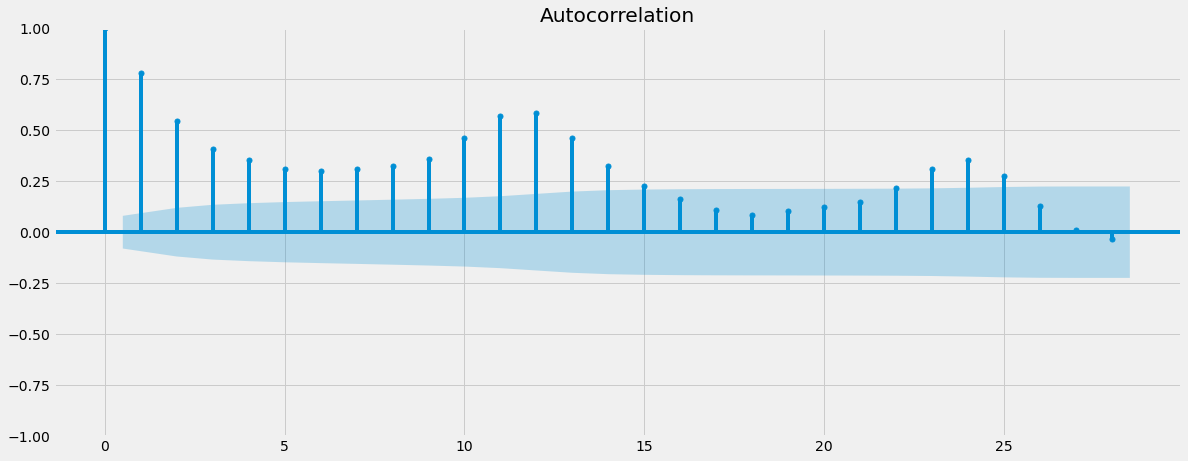

In [42]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

#### Looking at the chart, most of the vertical lines go beyond the blue edge of the confidence interval. This shows data non-stationarity.

#### It would be good to perform another round of differencing. 

In [43]:
# The df.shift(2) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff_2 = data_diff - data_diff.shift(2) 

In [44]:
#Remove the missing values that came about as a result of the differencing. 

data_diff_2.dropna(inplace = True) 

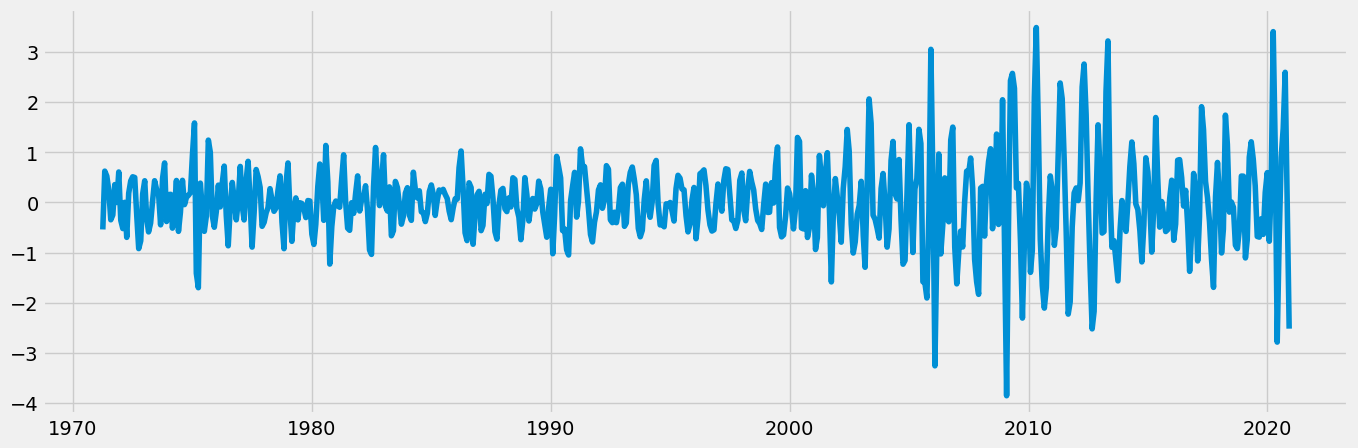

In [45]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [46]:
# Apply the test using the function on the time series

dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.476111
p-value                          0.000217
Number of Lags Used             19.000000
Number of Observations Used    577.000000
Critical Value (1%)             -3.441734
Critical Value (5%)             -2.866562
Critical Value (10%)            -2.569445
dtype: float64


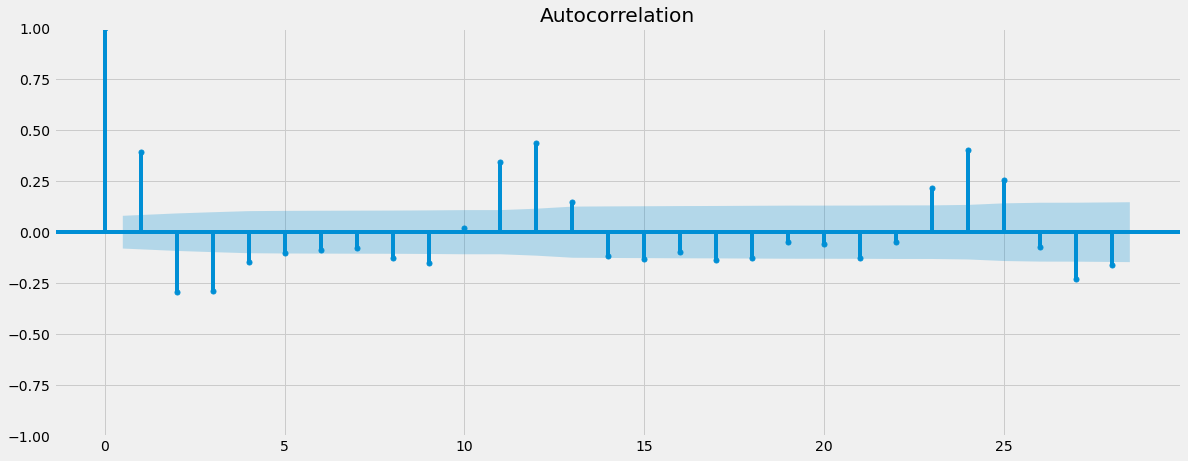

In [47]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show()

#### Looking at the chart, most of the vertical lines are under the blue edge of the confidence interval. This shows data stationarity.